# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
#data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

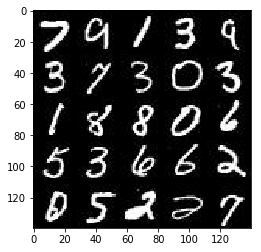

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

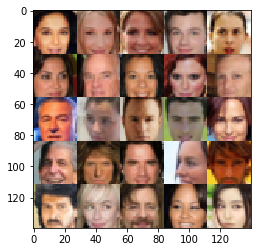

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_input = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name="real_input")
    z_input = tf.placeholder(tf.float32, (None, z_dim), name="fake_input")
    learning_rate = tf.placeholder(tf.float32, name="learning_rate")
    return real_input, z_input, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    alpha = 0.01
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        
        #first layer
        layer1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        layer1 = tf.maximum(alpha * layer1, layer1)
        
        #second layer
        layer2 = tf.layers.conv2d(layer1, 128, 5, strides=2, padding='same')
        layer2 = tf.layers.batch_normalization(layer2, training=True)
        layer2 = tf.maximum(alpha * layer2, layer2)
        
        #third layer
        layer3 = tf.layers.conv2d(layer2, 256, 5, strides=2, padding='same')
        layer3 = tf.layers.batch_normalization(layer3, training=True)
        layer3 = tf.maximum(alpha * layer3, layer3)

        #flatten layer 
        flat = tf.reshape(layer3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
    return(out, logits)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    alpha = 0.01
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse=not is_train):
        #fully connected layer
        layer1 = tf.layers.dense(z, 7*7*512)
        #reshape and relu
        layer1 = tf.reshape(layer1, (-1, 7, 7, 512))
        layer1 = tf.layers.batch_normalization(layer1, training=is_train)
        layer1 = tf.maximum(alpha * layer1, layer1)

        #second layer
        layer2 = tf.layers.conv2d_transpose(layer1, 256, 5, strides=2, padding='same')
        layer2 = tf.layers.batch_normalization(layer2, training=is_train)
        layer2 = tf.maximum(alpha * layer2, layer2)
        
        layer3 = tf.layers.conv2d_transpose(layer2, 128, 5, strides=2, padding='same')
        layer3 = tf.layers.batch_normalization(layer3, training=is_train)
        layer3 = tf.maximum(alpha * layer3, layer3)

        #logits and output
        logits = tf.layers.conv2d_transpose(layer3, out_channel_dim, 5, strides=1, padding='same')
        out = tf.tanh(logits)
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    return(d_loss, g_loss)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    #get the variables needed in a list
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    #optimize
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)    
    with tf.control_dependencies(update_ops):
        d_train_opr = tf.train.AdamOptimizer(learning_rate, beta1).minimize(d_loss, var_list = d_vars)
        g_train_opr = tf.train.AdamOptimizer(learning_rate, beta1).minimize(g_loss, var_list = g_vars)
    return(d_train_opr, g_train_opr)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    real_input, fake_input, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(real_input, fake_input, data_shape[3])
    d_train, g_train = model_opt(d_loss, g_loss, learning_rate, beta1)
    step = 0
       
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                step += 1
                batch_images = batch_images * 2
                #create the batch for z
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                #optimizations
                _ = sess.run(d_train, feed_dict={real_input: batch_images, fake_input:batch_z, lr:learning_rate})
                _ = sess.run(g_train, feed_dict={real_input: batch_images, fake_input:batch_z, lr:learning_rate})
                _ = sess.run(g_train, feed_dict={real_input: batch_images, fake_input:batch_z, lr:learning_rate})
                
                #print out the losses
                if step % 10 == 0:
                    discrimate_loss = sess.run(d_loss, feed_dict={real_input:batch_images, fake_input:batch_z})
                    generate_loss = sess.run(g_loss, feed_dict={fake_input:batch_z})
                    
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(discrimate_loss),
                          "Generator Loss: {:.4f}".format(generate_loss))
                #this is to show the generator like the item says every 100 steps
                if step % 100 == 0:
                    show_generator_output(sess, 25, fake_input, data_shape[3], data_image_mode)


### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.2123... Generator Loss: 1.8733
Epoch 1/2... Discriminator Loss: 1.6172... Generator Loss: 4.1553
Epoch 1/2... Discriminator Loss: 1.5739... Generator Loss: 1.2571
Epoch 1/2... Discriminator Loss: 2.2238... Generator Loss: 0.8258
Epoch 1/2... Discriminator Loss: 2.1346... Generator Loss: 0.4545
Epoch 1/2... Discriminator Loss: 2.0035... Generator Loss: 0.7503
Epoch 1/2... Discriminator Loss: 1.9456... Generator Loss: 0.4478
Epoch 1/2... Discriminator Loss: 1.9297... Generator Loss: 0.6146
Epoch 1/2... Discriminator Loss: 1.5788... Generator Loss: 0.9636
Epoch 1/2... Discriminator Loss: 1.7700... Generator Loss: 0.7250


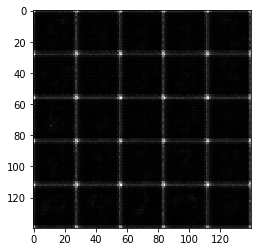

Epoch 1/2... Discriminator Loss: 1.4364... Generator Loss: 0.7126
Epoch 1/2... Discriminator Loss: 1.3696... Generator Loss: 0.7508
Epoch 1/2... Discriminator Loss: 1.6674... Generator Loss: 0.7939
Epoch 1/2... Discriminator Loss: 1.4292... Generator Loss: 0.9196
Epoch 1/2... Discriminator Loss: 1.4227... Generator Loss: 0.6410
Epoch 1/2... Discriminator Loss: 1.5283... Generator Loss: 0.8949
Epoch 1/2... Discriminator Loss: 1.5786... Generator Loss: 0.6976
Epoch 1/2... Discriminator Loss: 1.5357... Generator Loss: 0.4194
Epoch 1/2... Discriminator Loss: 1.8933... Generator Loss: 0.2511
Epoch 1/2... Discriminator Loss: 2.2926... Generator Loss: 0.1355


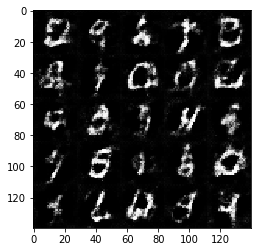

Epoch 1/2... Discriminator Loss: 2.1775... Generator Loss: 0.1537
Epoch 1/2... Discriminator Loss: 1.6862... Generator Loss: 0.8267
Epoch 1/2... Discriminator Loss: 1.8773... Generator Loss: 0.4908
Epoch 1/2... Discriminator Loss: 1.7086... Generator Loss: 0.6053
Epoch 1/2... Discriminator Loss: 1.6486... Generator Loss: 0.4645
Epoch 1/2... Discriminator Loss: 1.6583... Generator Loss: 0.7058
Epoch 1/2... Discriminator Loss: 1.5365... Generator Loss: 0.7964
Epoch 1/2... Discriminator Loss: 1.6696... Generator Loss: 0.5155
Epoch 1/2... Discriminator Loss: 1.5879... Generator Loss: 0.5070
Epoch 1/2... Discriminator Loss: 1.6649... Generator Loss: 0.6565


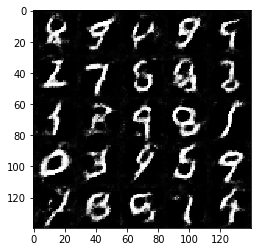

Epoch 1/2... Discriminator Loss: 1.8930... Generator Loss: 0.2332
Epoch 1/2... Discriminator Loss: 1.9751... Generator Loss: 0.2038
Epoch 1/2... Discriminator Loss: 1.8703... Generator Loss: 0.2497
Epoch 1/2... Discriminator Loss: 1.7511... Generator Loss: 0.2963
Epoch 1/2... Discriminator Loss: 1.6258... Generator Loss: 0.5307
Epoch 1/2... Discriminator Loss: 1.6609... Generator Loss: 0.6606
Epoch 1/2... Discriminator Loss: 1.5677... Generator Loss: 0.5835
Epoch 1/2... Discriminator Loss: 1.5991... Generator Loss: 0.6085
Epoch 1/2... Discriminator Loss: 1.6475... Generator Loss: 0.6154
Epoch 1/2... Discriminator Loss: 1.5670... Generator Loss: 0.4458


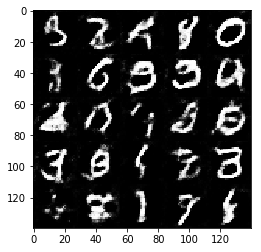

Epoch 1/2... Discriminator Loss: 1.8900... Generator Loss: 0.2118
Epoch 1/2... Discriminator Loss: 1.8154... Generator Loss: 0.2598
Epoch 1/2... Discriminator Loss: 1.9595... Generator Loss: 0.2001
Epoch 1/2... Discriminator Loss: 1.7607... Generator Loss: 0.2798
Epoch 1/2... Discriminator Loss: 1.6779... Generator Loss: 0.3421
Epoch 1/2... Discriminator Loss: 2.0476... Generator Loss: 0.1841
Epoch 1/2... Discriminator Loss: 1.5739... Generator Loss: 0.4505
Epoch 1/2... Discriminator Loss: 1.6210... Generator Loss: 0.7293
Epoch 1/2... Discriminator Loss: 1.5273... Generator Loss: 0.6513
Epoch 1/2... Discriminator Loss: 1.4856... Generator Loss: 0.6943


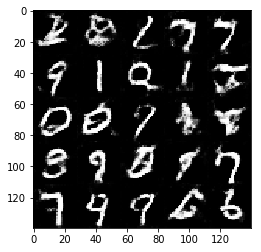

Epoch 1/2... Discriminator Loss: 1.6071... Generator Loss: 0.3846
Epoch 1/2... Discriminator Loss: 1.4766... Generator Loss: 0.6883
Epoch 1/2... Discriminator Loss: 1.6117... Generator Loss: 0.4929
Epoch 1/2... Discriminator Loss: 1.6561... Generator Loss: 0.6360
Epoch 1/2... Discriminator Loss: 1.6237... Generator Loss: 0.6393
Epoch 1/2... Discriminator Loss: 1.5697... Generator Loss: 0.6246
Epoch 1/2... Discriminator Loss: 1.5454... Generator Loss: 0.5069
Epoch 1/2... Discriminator Loss: 1.5665... Generator Loss: 0.7451
Epoch 1/2... Discriminator Loss: 1.6032... Generator Loss: 0.5834
Epoch 1/2... Discriminator Loss: 1.3986... Generator Loss: 0.6679


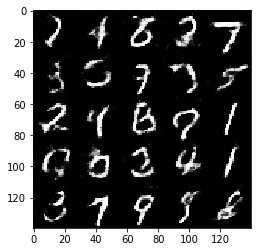

Epoch 1/2... Discriminator Loss: 1.5981... Generator Loss: 0.7880
Epoch 1/2... Discriminator Loss: 1.4917... Generator Loss: 0.5001
Epoch 1/2... Discriminator Loss: 1.6014... Generator Loss: 0.6647
Epoch 1/2... Discriminator Loss: 1.4968... Generator Loss: 0.5816
Epoch 1/2... Discriminator Loss: 1.6489... Generator Loss: 0.3205
Epoch 1/2... Discriminator Loss: 1.7245... Generator Loss: 0.2751
Epoch 1/2... Discriminator Loss: 1.4437... Generator Loss: 0.5764
Epoch 1/2... Discriminator Loss: 1.4353... Generator Loss: 0.6458
Epoch 1/2... Discriminator Loss: 1.4753... Generator Loss: 0.5056
Epoch 1/2... Discriminator Loss: 1.6490... Generator Loss: 0.4623


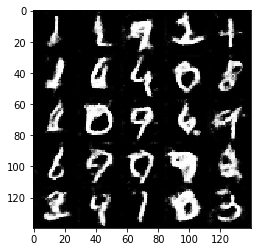

Epoch 1/2... Discriminator Loss: 1.3621... Generator Loss: 0.7178
Epoch 1/2... Discriminator Loss: 1.6067... Generator Loss: 0.7467
Epoch 1/2... Discriminator Loss: 1.4633... Generator Loss: 0.4497
Epoch 1/2... Discriminator Loss: 1.6262... Generator Loss: 0.4102
Epoch 1/2... Discriminator Loss: 1.3857... Generator Loss: 1.0001
Epoch 1/2... Discriminator Loss: 1.3540... Generator Loss: 0.6898
Epoch 1/2... Discriminator Loss: 1.4489... Generator Loss: 0.5326
Epoch 1/2... Discriminator Loss: 3.0071... Generator Loss: 0.0621
Epoch 1/2... Discriminator Loss: 1.5578... Generator Loss: 0.3705
Epoch 1/2... Discriminator Loss: 1.8520... Generator Loss: 0.2320


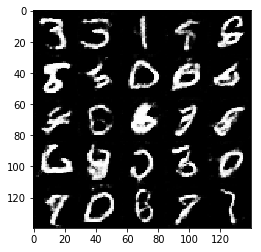

Epoch 1/2... Discriminator Loss: 1.7064... Generator Loss: 0.2757
Epoch 1/2... Discriminator Loss: 1.7443... Generator Loss: 0.2763
Epoch 1/2... Discriminator Loss: 1.8457... Generator Loss: 0.2347
Epoch 1/2... Discriminator Loss: 1.7407... Generator Loss: 0.2779
Epoch 1/2... Discriminator Loss: 1.8406... Generator Loss: 0.2419
Epoch 1/2... Discriminator Loss: 1.7386... Generator Loss: 0.2583
Epoch 1/2... Discriminator Loss: 1.7760... Generator Loss: 0.2399
Epoch 1/2... Discriminator Loss: 1.6860... Generator Loss: 0.2962
Epoch 1/2... Discriminator Loss: 1.4714... Generator Loss: 0.4888
Epoch 1/2... Discriminator Loss: 1.8587... Generator Loss: 0.2168


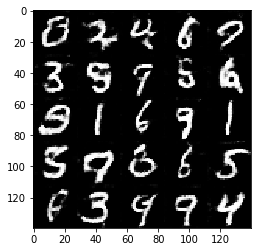

Epoch 1/2... Discriminator Loss: 1.5894... Generator Loss: 0.3823
Epoch 1/2... Discriminator Loss: 2.1464... Generator Loss: 0.1705
Epoch 1/2... Discriminator Loss: 1.6391... Generator Loss: 0.3170
Epoch 2/2... Discriminator Loss: 1.5890... Generator Loss: 0.3580
Epoch 2/2... Discriminator Loss: 1.9498... Generator Loss: 0.1959
Epoch 2/2... Discriminator Loss: 1.5339... Generator Loss: 0.3847
Epoch 2/2... Discriminator Loss: 1.2983... Generator Loss: 0.7447
Epoch 2/2... Discriminator Loss: 1.3370... Generator Loss: 0.8899
Epoch 2/2... Discriminator Loss: 1.5450... Generator Loss: 0.5449
Epoch 2/2... Discriminator Loss: 1.6088... Generator Loss: 0.6131


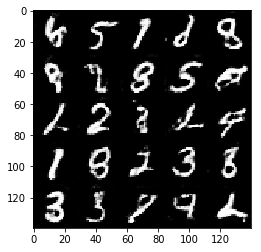

Epoch 2/2... Discriminator Loss: 1.8750... Generator Loss: 0.2069
Epoch 2/2... Discriminator Loss: 1.8459... Generator Loss: 0.2348
Epoch 2/2... Discriminator Loss: 1.3939... Generator Loss: 0.7003
Epoch 2/2... Discriminator Loss: 1.4843... Generator Loss: 0.6184
Epoch 2/2... Discriminator Loss: 1.5150... Generator Loss: 0.3843
Epoch 2/2... Discriminator Loss: 2.0718... Generator Loss: 0.1652
Epoch 2/2... Discriminator Loss: 1.6664... Generator Loss: 0.3203
Epoch 2/2... Discriminator Loss: 2.2227... Generator Loss: 0.1340
Epoch 2/2... Discriminator Loss: 1.6995... Generator Loss: 0.2760
Epoch 2/2... Discriminator Loss: 1.5316... Generator Loss: 0.3502


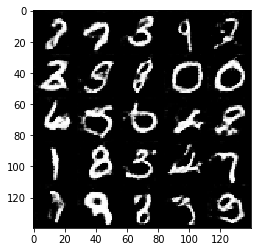

Epoch 2/2... Discriminator Loss: 1.9312... Generator Loss: 0.1986
Epoch 2/2... Discriminator Loss: 1.7340... Generator Loss: 0.2464
Epoch 2/2... Discriminator Loss: 1.6346... Generator Loss: 0.3614
Epoch 2/2... Discriminator Loss: 1.6486... Generator Loss: 0.2837
Epoch 2/2... Discriminator Loss: 1.9075... Generator Loss: 0.2124
Epoch 2/2... Discriminator Loss: 1.6112... Generator Loss: 0.3327
Epoch 2/2... Discriminator Loss: 1.2449... Generator Loss: 0.6894
Epoch 2/2... Discriminator Loss: 1.4771... Generator Loss: 0.8424
Epoch 2/2... Discriminator Loss: 1.6209... Generator Loss: 0.3152
Epoch 2/2... Discriminator Loss: 1.6509... Generator Loss: 0.2882


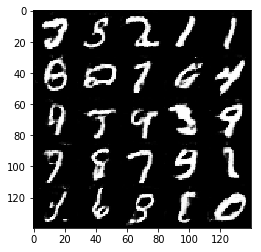

Epoch 2/2... Discriminator Loss: 1.7228... Generator Loss: 0.2554
Epoch 2/2... Discriminator Loss: 1.4263... Generator Loss: 0.4416
Epoch 2/2... Discriminator Loss: 1.4603... Generator Loss: 0.4472
Epoch 2/2... Discriminator Loss: 1.3950... Generator Loss: 1.1343
Epoch 2/2... Discriminator Loss: 1.2125... Generator Loss: 0.8412
Epoch 2/2... Discriminator Loss: 1.1696... Generator Loss: 0.8009
Epoch 2/2... Discriminator Loss: 1.1768... Generator Loss: 0.7280
Epoch 2/2... Discriminator Loss: 1.4163... Generator Loss: 0.6844
Epoch 2/2... Discriminator Loss: 1.5828... Generator Loss: 0.3614
Epoch 2/2... Discriminator Loss: 1.4384... Generator Loss: 0.3832


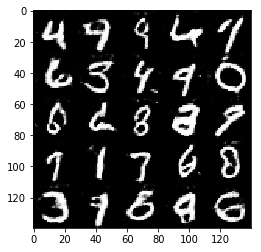

Epoch 2/2... Discriminator Loss: 1.8873... Generator Loss: 0.2085
Epoch 2/2... Discriminator Loss: 1.5782... Generator Loss: 0.3218
Epoch 2/2... Discriminator Loss: 1.3587... Generator Loss: 0.5954
Epoch 2/2... Discriminator Loss: 1.6155... Generator Loss: 1.2184
Epoch 2/2... Discriminator Loss: 1.3119... Generator Loss: 0.5908
Epoch 2/2... Discriminator Loss: 1.4943... Generator Loss: 0.3632
Epoch 2/2... Discriminator Loss: 2.2767... Generator Loss: 0.1351
Epoch 2/2... Discriminator Loss: 1.3083... Generator Loss: 0.5113
Epoch 2/2... Discriminator Loss: 1.2586... Generator Loss: 0.5331
Epoch 2/2... Discriminator Loss: 1.6490... Generator Loss: 0.6215


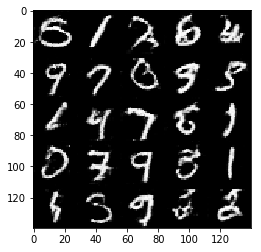

Epoch 2/2... Discriminator Loss: 1.3208... Generator Loss: 0.5659
Epoch 2/2... Discriminator Loss: 1.3373... Generator Loss: 0.5537
Epoch 2/2... Discriminator Loss: 1.6468... Generator Loss: 0.8672
Epoch 2/2... Discriminator Loss: 1.6850... Generator Loss: 0.2643
Epoch 2/2... Discriminator Loss: 1.7791... Generator Loss: 0.2335
Epoch 2/2... Discriminator Loss: 1.5202... Generator Loss: 0.3640
Epoch 2/2... Discriminator Loss: 1.3620... Generator Loss: 0.4013
Epoch 2/2... Discriminator Loss: 1.6781... Generator Loss: 0.2823
Epoch 2/2... Discriminator Loss: 1.9049... Generator Loss: 0.2185
Epoch 2/2... Discriminator Loss: 1.5230... Generator Loss: 0.3887


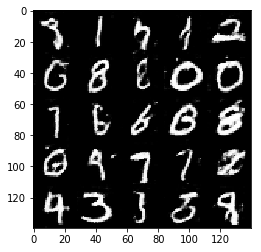

Epoch 2/2... Discriminator Loss: 1.7338... Generator Loss: 0.8535
Epoch 2/2... Discriminator Loss: 1.5747... Generator Loss: 0.3417
Epoch 2/2... Discriminator Loss: 1.2559... Generator Loss: 0.8613
Epoch 2/2... Discriminator Loss: 1.8041... Generator Loss: 0.2371
Epoch 2/2... Discriminator Loss: 1.3868... Generator Loss: 0.4225
Epoch 2/2... Discriminator Loss: 1.6337... Generator Loss: 0.8778
Epoch 2/2... Discriminator Loss: 1.3379... Generator Loss: 0.5157
Epoch 2/2... Discriminator Loss: 1.1602... Generator Loss: 0.7666
Epoch 2/2... Discriminator Loss: 1.6454... Generator Loss: 1.1181
Epoch 2/2... Discriminator Loss: 1.3370... Generator Loss: 0.5676


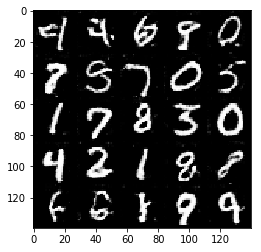

Epoch 2/2... Discriminator Loss: 1.3088... Generator Loss: 0.7777
Epoch 2/2... Discriminator Loss: 1.4203... Generator Loss: 0.5131
Epoch 2/2... Discriminator Loss: 1.3746... Generator Loss: 0.4148
Epoch 2/2... Discriminator Loss: 1.8227... Generator Loss: 0.9892
Epoch 2/2... Discriminator Loss: 1.3656... Generator Loss: 0.7572
Epoch 2/2... Discriminator Loss: 1.2799... Generator Loss: 0.8527
Epoch 2/2... Discriminator Loss: 1.1969... Generator Loss: 0.6908
Epoch 2/2... Discriminator Loss: 1.3027... Generator Loss: 0.4743
Epoch 2/2... Discriminator Loss: 1.8228... Generator Loss: 0.2190
Epoch 2/2... Discriminator Loss: 1.2293... Generator Loss: 0.5045


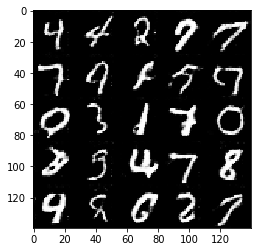

Epoch 2/2... Discriminator Loss: 1.2794... Generator Loss: 0.9630
Epoch 2/2... Discriminator Loss: 1.7946... Generator Loss: 0.2357
Epoch 2/2... Discriminator Loss: 1.5169... Generator Loss: 0.3342
Epoch 2/2... Discriminator Loss: 1.9309... Generator Loss: 0.1979
Epoch 2/2... Discriminator Loss: 1.4737... Generator Loss: 0.3587
Epoch 2/2... Discriminator Loss: 1.1830... Generator Loss: 0.7019
Epoch 2/2... Discriminator Loss: 1.7462... Generator Loss: 0.2502
Epoch 2/2... Discriminator Loss: 1.2992... Generator Loss: 0.4408
Epoch 2/2... Discriminator Loss: 1.5566... Generator Loss: 0.2987
Epoch 2/2... Discriminator Loss: 1.8520... Generator Loss: 0.2168


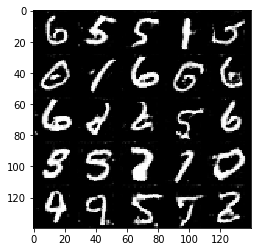

Epoch 2/2... Discriminator Loss: 1.1750... Generator Loss: 0.8335
Epoch 2/2... Discriminator Loss: 1.2896... Generator Loss: 0.6533
Epoch 2/2... Discriminator Loss: 1.1694... Generator Loss: 0.6647
Epoch 2/2... Discriminator Loss: 1.1956... Generator Loss: 1.0900
Epoch 2/2... Discriminator Loss: 1.0546... Generator Loss: 1.0947
Epoch 2/2... Discriminator Loss: 1.5416... Generator Loss: 0.3326
Epoch 2/2... Discriminator Loss: 1.8398... Generator Loss: 0.2286


In [13]:
batch_size = 64
z_dim = 150
learning_rate = 0.0002
beta1 = .05


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.8010... Generator Loss: 1.3793
Epoch 1/1... Discriminator Loss: 1.7982... Generator Loss: 0.5033
Epoch 1/1... Discriminator Loss: 2.2393... Generator Loss: 0.2662
Epoch 1/1... Discriminator Loss: 2.0640... Generator Loss: 0.3736
Epoch 1/1... Discriminator Loss: 2.0960... Generator Loss: 0.6100
Epoch 1/1... Discriminator Loss: 2.0707... Generator Loss: 0.3626
Epoch 1/1... Discriminator Loss: 1.8146... Generator Loss: 1.3969
Epoch 1/1... Discriminator Loss: 1.5707... Generator Loss: 0.4989
Epoch 1/1... Discriminator Loss: 1.7353... Generator Loss: 0.3095
Epoch 1/1... Discriminator Loss: 1.2690... Generator Loss: 0.9608


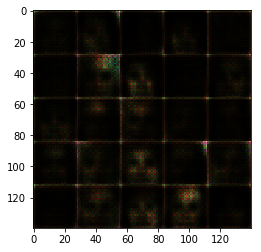

Epoch 1/1... Discriminator Loss: 1.5484... Generator Loss: 0.6058
Epoch 1/1... Discriminator Loss: 1.3092... Generator Loss: 0.7275
Epoch 1/1... Discriminator Loss: 1.6020... Generator Loss: 0.4202
Epoch 1/1... Discriminator Loss: 0.6232... Generator Loss: 1.7423
Epoch 1/1... Discriminator Loss: 1.4415... Generator Loss: 0.6450
Epoch 1/1... Discriminator Loss: 1.5522... Generator Loss: 0.9935
Epoch 1/1... Discriminator Loss: 2.1045... Generator Loss: 0.3245
Epoch 1/1... Discriminator Loss: 2.0398... Generator Loss: 0.2349
Epoch 1/1... Discriminator Loss: 1.9616... Generator Loss: 0.2971
Epoch 1/1... Discriminator Loss: 1.5415... Generator Loss: 0.8785


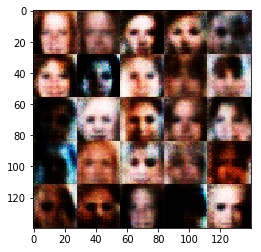

Epoch 1/1... Discriminator Loss: 2.0614... Generator Loss: 0.2281
Epoch 1/1... Discriminator Loss: 0.9380... Generator Loss: 1.2349
Epoch 1/1... Discriminator Loss: 1.0831... Generator Loss: 2.2697
Epoch 1/1... Discriminator Loss: 1.6256... Generator Loss: 0.3426
Epoch 1/1... Discriminator Loss: 1.8155... Generator Loss: 0.4782
Epoch 1/1... Discriminator Loss: 1.3453... Generator Loss: 1.2354
Epoch 1/1... Discriminator Loss: 1.7016... Generator Loss: 0.4441
Epoch 1/1... Discriminator Loss: 1.7999... Generator Loss: 0.3736
Epoch 1/1... Discriminator Loss: 1.3614... Generator Loss: 0.8045
Epoch 1/1... Discriminator Loss: 1.6849... Generator Loss: 0.5248


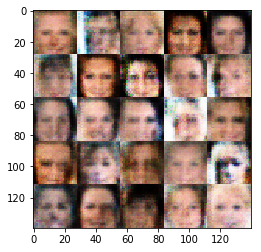

Epoch 1/1... Discriminator Loss: 1.4124... Generator Loss: 0.7481
Epoch 1/1... Discriminator Loss: 1.2760... Generator Loss: 0.8690
Epoch 1/1... Discriminator Loss: 1.6807... Generator Loss: 0.5800
Epoch 1/1... Discriminator Loss: 1.8240... Generator Loss: 0.3835
Epoch 1/1... Discriminator Loss: 1.3445... Generator Loss: 0.9064
Epoch 1/1... Discriminator Loss: 1.4788... Generator Loss: 0.5928
Epoch 1/1... Discriminator Loss: 1.4143... Generator Loss: 0.6616
Epoch 1/1... Discriminator Loss: 1.6238... Generator Loss: 0.5947
Epoch 1/1... Discriminator Loss: 1.6071... Generator Loss: 0.5472
Epoch 1/1... Discriminator Loss: 1.7375... Generator Loss: 0.5051


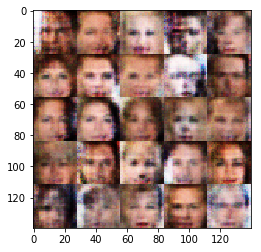

Epoch 1/1... Discriminator Loss: 1.6408... Generator Loss: 0.4595
Epoch 1/1... Discriminator Loss: 1.5965... Generator Loss: 0.5978
Epoch 1/1... Discriminator Loss: 1.6475... Generator Loss: 0.5353
Epoch 1/1... Discriminator Loss: 1.6254... Generator Loss: 0.4978
Epoch 1/1... Discriminator Loss: 1.5559... Generator Loss: 0.5743
Epoch 1/1... Discriminator Loss: 1.5958... Generator Loss: 0.5716
Epoch 1/1... Discriminator Loss: 1.6662... Generator Loss: 0.5015
Epoch 1/1... Discriminator Loss: 1.5038... Generator Loss: 0.6055
Epoch 1/1... Discriminator Loss: 1.5863... Generator Loss: 0.5579
Epoch 1/1... Discriminator Loss: 1.5731... Generator Loss: 0.5697


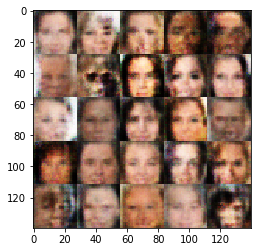

Epoch 1/1... Discriminator Loss: 1.5057... Generator Loss: 0.6141
Epoch 1/1... Discriminator Loss: 1.4845... Generator Loss: 0.6169
Epoch 1/1... Discriminator Loss: 1.5555... Generator Loss: 0.5742
Epoch 1/1... Discriminator Loss: 1.6093... Generator Loss: 0.5535
Epoch 1/1... Discriminator Loss: 1.5319... Generator Loss: 0.5825
Epoch 1/1... Discriminator Loss: 1.5775... Generator Loss: 0.6077
Epoch 1/1... Discriminator Loss: 1.5218... Generator Loss: 0.6019
Epoch 1/1... Discriminator Loss: 1.5180... Generator Loss: 0.6271
Epoch 1/1... Discriminator Loss: 1.5498... Generator Loss: 0.5813
Epoch 1/1... Discriminator Loss: 1.5189... Generator Loss: 0.6131


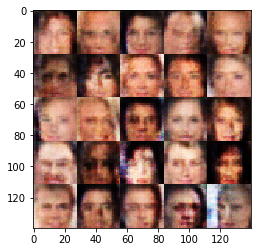

Epoch 1/1... Discriminator Loss: 1.5369... Generator Loss: 0.6016
Epoch 1/1... Discriminator Loss: 1.5113... Generator Loss: 0.6045
Epoch 1/1... Discriminator Loss: 1.5600... Generator Loss: 0.5880
Epoch 1/1... Discriminator Loss: 1.5050... Generator Loss: 0.6163
Epoch 1/1... Discriminator Loss: 1.5396... Generator Loss: 0.5725
Epoch 1/1... Discriminator Loss: 1.5685... Generator Loss: 0.5801
Epoch 1/1... Discriminator Loss: 1.5443... Generator Loss: 0.5927
Epoch 1/1... Discriminator Loss: 1.5623... Generator Loss: 0.5799
Epoch 1/1... Discriminator Loss: 1.4912... Generator Loss: 0.6034
Epoch 1/1... Discriminator Loss: 1.5278... Generator Loss: 0.5897


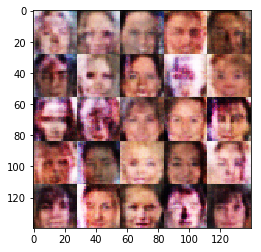

Epoch 1/1... Discriminator Loss: 1.4721... Generator Loss: 0.6272
Epoch 1/1... Discriminator Loss: 1.4387... Generator Loss: 0.6343
Epoch 1/1... Discriminator Loss: 1.4872... Generator Loss: 0.6065
Epoch 1/1... Discriminator Loss: 1.4671... Generator Loss: 0.6371
Epoch 1/1... Discriminator Loss: 1.5521... Generator Loss: 0.5528
Epoch 1/1... Discriminator Loss: 1.4818... Generator Loss: 0.6154
Epoch 1/1... Discriminator Loss: 1.4584... Generator Loss: 0.6163
Epoch 1/1... Discriminator Loss: 1.4878... Generator Loss: 0.5735
Epoch 1/1... Discriminator Loss: 1.4719... Generator Loss: 0.6136
Epoch 1/1... Discriminator Loss: 1.4996... Generator Loss: 0.6048


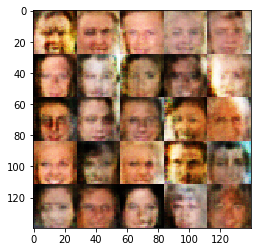

Epoch 1/1... Discriminator Loss: 1.4993... Generator Loss: 0.5977
Epoch 1/1... Discriminator Loss: 1.4969... Generator Loss: 0.6088
Epoch 1/1... Discriminator Loss: 1.4728... Generator Loss: 0.6372
Epoch 1/1... Discriminator Loss: 1.5008... Generator Loss: 0.6124
Epoch 1/1... Discriminator Loss: 1.5125... Generator Loss: 0.6199
Epoch 1/1... Discriminator Loss: 1.4073... Generator Loss: 0.6598
Epoch 1/1... Discriminator Loss: 1.4819... Generator Loss: 0.6121
Epoch 1/1... Discriminator Loss: 1.4446... Generator Loss: 0.6340
Epoch 1/1... Discriminator Loss: 1.4720... Generator Loss: 0.6191
Epoch 1/1... Discriminator Loss: 1.4476... Generator Loss: 0.6331


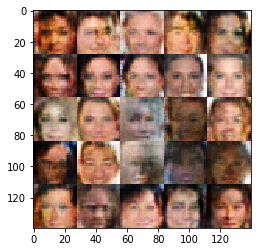

Epoch 1/1... Discriminator Loss: 1.4495... Generator Loss: 0.6219
Epoch 1/1... Discriminator Loss: 1.4781... Generator Loss: 0.6027
Epoch 1/1... Discriminator Loss: 1.5077... Generator Loss: 0.5876
Epoch 1/1... Discriminator Loss: 1.4777... Generator Loss: 0.5958
Epoch 1/1... Discriminator Loss: 1.4731... Generator Loss: 0.6155
Epoch 1/1... Discriminator Loss: 1.4957... Generator Loss: 0.6235
Epoch 1/1... Discriminator Loss: 1.4985... Generator Loss: 0.6052
Epoch 1/1... Discriminator Loss: 1.4480... Generator Loss: 0.6521
Epoch 1/1... Discriminator Loss: 1.4655... Generator Loss: 0.6480
Epoch 1/1... Discriminator Loss: 1.4356... Generator Loss: 0.6270


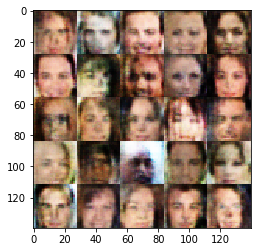

Epoch 1/1... Discriminator Loss: 1.4924... Generator Loss: 0.6012
Epoch 1/1... Discriminator Loss: 1.5273... Generator Loss: 0.5726
Epoch 1/1... Discriminator Loss: 1.4679... Generator Loss: 0.6290
Epoch 1/1... Discriminator Loss: 1.4074... Generator Loss: 0.6231
Epoch 1/1... Discriminator Loss: 1.5184... Generator Loss: 0.6124
Epoch 1/1... Discriminator Loss: 1.4696... Generator Loss: 0.6161
Epoch 1/1... Discriminator Loss: 1.4653... Generator Loss: 0.6287
Epoch 1/1... Discriminator Loss: 1.4865... Generator Loss: 0.6178
Epoch 1/1... Discriminator Loss: 1.5262... Generator Loss: 0.6014
Epoch 1/1... Discriminator Loss: 1.4825... Generator Loss: 0.6240


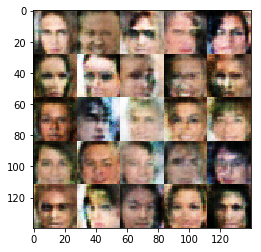

Epoch 1/1... Discriminator Loss: 1.4856... Generator Loss: 0.6254
Epoch 1/1... Discriminator Loss: 1.4760... Generator Loss: 0.6015
Epoch 1/1... Discriminator Loss: 1.4570... Generator Loss: 0.6530
Epoch 1/1... Discriminator Loss: 1.5000... Generator Loss: 0.6030
Epoch 1/1... Discriminator Loss: 1.4654... Generator Loss: 0.6434
Epoch 1/1... Discriminator Loss: 1.4199... Generator Loss: 0.6471
Epoch 1/1... Discriminator Loss: 1.4591... Generator Loss: 0.6147
Epoch 1/1... Discriminator Loss: 1.4691... Generator Loss: 0.6267
Epoch 1/1... Discriminator Loss: 1.4558... Generator Loss: 0.6210
Epoch 1/1... Discriminator Loss: 1.4455... Generator Loss: 0.6206


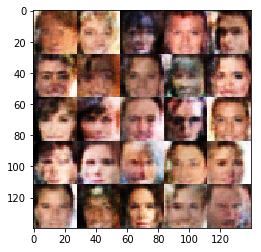

Epoch 1/1... Discriminator Loss: 1.4455... Generator Loss: 0.6247
Epoch 1/1... Discriminator Loss: 1.4823... Generator Loss: 0.6101
Epoch 1/1... Discriminator Loss: 1.5348... Generator Loss: 0.6116
Epoch 1/1... Discriminator Loss: 1.4966... Generator Loss: 0.6163
Epoch 1/1... Discriminator Loss: 1.4849... Generator Loss: 0.6141
Epoch 1/1... Discriminator Loss: 1.4731... Generator Loss: 0.6037
Epoch 1/1... Discriminator Loss: 1.4908... Generator Loss: 0.6011
Epoch 1/1... Discriminator Loss: 1.4322... Generator Loss: 0.6731
Epoch 1/1... Discriminator Loss: 1.4865... Generator Loss: 0.6131


In [ ]:
batch_size = 125
z_dim = 150
learning_rate = 0.0002
beta1 = .5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.